# LSTM Autoencoder for anomaly detection

시계열 자료의 이상치 검출

## Data download 
https://finance.yahoo.com/quote/GE/history?p=GE

In [176]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [177]:
df = pd.read_csv('data/GE.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1970-01-02,6.209936,6.219952,6.129808,6.139824,1.270701,289536
1,1970-01-05,6.139824,6.169872,6.059696,6.109776,1.264482,529152
2,1970-01-06,6.099760,6.099760,5.899439,5.929487,1.227170,443040
3,1970-01-07,5.949519,6.039663,5.949519,5.959535,1.233389,575328
4,1970-01-08,5.979567,6.069712,5.979567,6.009615,1.243753,1737216


In [178]:
df = df.loc[:, ['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.head(3)

,Date,Close
0,1970-01-02,6.139824
1,1970-01-05,6.109776
2,1970-01-06,5.929487


In [181]:
df.tail(3)

,Date,Close
12819,2020-10-26,59.040001
12820,2020-10-27,56.799999
12821,2020-10-28,59.360001


Start date is:  1970-01-02 00:00:00
End date is:  2020-10-28 00:00:00


((8586, 2), (4236, 2))

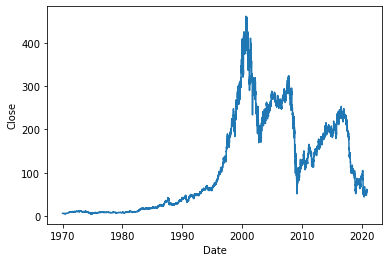

In [179]:
sns.lineplot(x=df['Date'], y=df['Close'])

print("Start date is: ", df['Date'].min())
print("End date is: ", df['Date'].max())

train, test = df.loc[df['Date'] <= '2003-12-31'], df.loc[df['Date'] > '2003-12-31']
train.shape, test.shape

### input data normalization

In [131]:
sc = StandardScaler()
train.loc[:, ['Close']] = sc.fit_transform(train[['Close']])
test.loc[:, ['Close']] = sc.transform(test[['Close']])

### 시계열 data 의 지도학습 data 변환

In [146]:
seq_size = 30

def seq_to_supervised(x, y, window):
    x_values = []
    y_values = []
    for i in range(len(x)-window):
        x_values.append(x.iloc[i:(i+window)])
        y_values.append(y.iloc[i+window])
    return np.array(x_values), np.array(y_values)

X_train, y_train = seq_to_supervised(train[['Close']], train[['Close']], seq_size)
X_test, y_test = seq_to_supervised(test[['Close']], test[['Close']], seq_size)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8556, 30, 1), (8556, 1), (4206, 30, 1), (4206, 1))

## LSTM Autoencoder model 

Input: 30 timesteps, 1 feature (univariate)  -> 30x1  
Layer1(lstm) : Outputs 128 features with 30 timesteps (return_sequences=True)  
Layer2(lstm_1) : 30x128 input and outputs 64 features (return_sequences=False -> 1x64) -> encoded vector  
Layer3 : RepeatVector. encoder 와 decoder 연결. 1x64를 30 번 copy 하여 30 timesteps 로 연결.
Layer4(lstm_2) : Layer3 와 유사.
Layer5(lstm_3): Layer1 과 유사.
Layer6 : TimeDistributed (30,1). 이전 layer와 같은 숫자의 feature (128) 를 생성.

Note: Layer5는 30x128 이고 TimeDistributed 는 128x1. 둘을 matmul 하면 30x1  출력


<img src="https://www.researchgate.net/profile/Hoang_Duy_Trinh2/publication/336594630/figure/fig2/AS:814792885420033@1571273170513/LSTM-Autoencoder-for-Anomaly-Detection.png" width=400 />

In [186]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(RepeatVector(X_train.shape[1]))
# model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dense(X_train.shape[2]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_33 (LSTM)              (None, 30, 128)           131584    
                                                                 
 dense_6 (Dense)             (None, 30, 1)             129       
                                                     

Epoch 1/10
241/241 [==============================] - 7s 25ms/step - loss: 0.0652 - val_loss: 0.0599
Epoch 2/10
241/241 [==============================] - 6s 24ms/step - loss: 0.0077 - val_loss: 0.0148
Epoch 3/10
241/241 [==============================] - 7s 29ms/step - loss: 0.0052 - val_loss: 0.0172
Epoch 4/10
241/241 [==============================] - 7s 29ms/step - loss: 0.0038 - val_loss: 0.0195
Epoch 5/10
241/241 [==============================] - 7s 29ms/step - loss: 0.0037 - val_loss: 0.0348
Epoch 6/10
241/241 [==============================] - 7s 28ms/step - loss: 0.0032 - val_loss: 0.0244
Epoch 7/10
241/241 [==============================] - 7s 29ms/step - loss: 0.0032 - val_loss: 0.0505
Epoch 8/10
241/241 [==============================] - 7s 29ms/step - loss: 0.0025 - val_loss: 0.0198
Epoch 9/10
241/241 [==============================] - 7s 30ms/step - loss: 0.0029 - val_loss: 0.0111
Epoch 10/10
241/241 [==============================] - 7s 28ms/step - loss: 0.0025 - val_lo

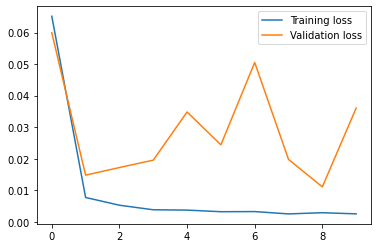

In [187]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

원본 data (X_train) 의 재구성 오류 측정 :  data (trainPredict) 와 X_train 간의 mean absolute error 측정

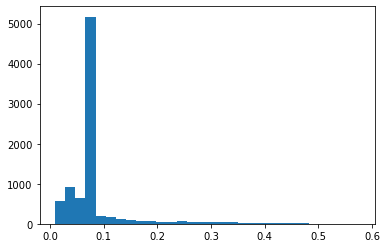

In [189]:
trainPredict = model.predict(X_train)
trainMAE = np.mean(np.abs(trainPredict - X_train), axis=1)
plt.hist(trainMAE, bins=30)
None

시각적으로 threshold 설정 또는 max value의 90% 를 threshold 로 지정.

In [190]:
max(trainMAE) * 0.9

array([0.51861693])

In [193]:
max_trainMAE = 0.3  #or Define 90% value of max as threshold.

- X_test data 의 재구성 오류 측정

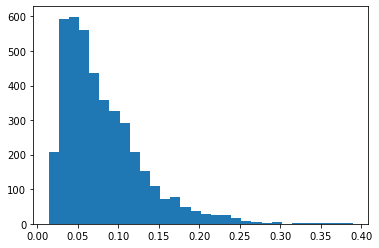

In [194]:
testPredict = model.predict(X_test)
testMAE = np.mean(np.abs(testPredict - X_test), axis=1)
plt.hist(testMAE, bins=30)
None

In [195]:
# 용이한 시각화를 위해 DataFrame으로 구성
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']
anomaly_df.head()

,Date,Close,testMAE,max_trainMAE,anomaly
8616,2004-02-17,254.230774,0.096472,0.3,False
8617,2004-02-18,251.923080,0.097788,0.3,False
8618,2004-02-19,250.769226,0.099491,0.3,False
8619,2004-02-20,251.538467,0.104218,0.3,False
8620,2004-02-23,257.076935,0.109462,0.3,False


In [197]:
# 이상치  data
anomaly_df[anomaly_df['anomaly'] ==  True]

,Date,Close,testMAE,max_trainMAE,anomaly
9785,2008-10-07,156.153839,0.301885,0.3,True
9786,2008-10-08,158.846161,0.336209,0.3,True
9787,2008-10-09,146.230774,0.354744,0.3,True
9788,2008-10-10,165.384613,0.389927,0.3,True
9789,2008-10-13,161.538467,0.375172,0.3,True
9790,2008-10-14,160.384613,0.360468,0.3,True
9791,2008-10-15,148.076920,0.341385,0.3,True
9792,2008-10-16,153.000000,0.341710,0.3,True
9793,2008-10-17,151.000000,0.329200,0.3,True
9794,2008-10-20,154.923080,0.316356,0.3,True


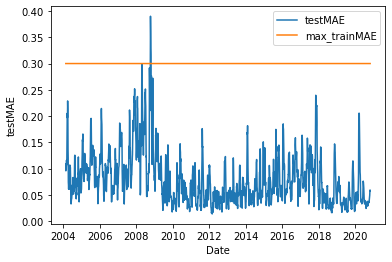

In [198]:
#Plot testMAE vs max_trainMAE
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'], label='testMAE')
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'], label='max_trainMAE')
plt.legend()

<AxesSubplot:xlabel='Date'>

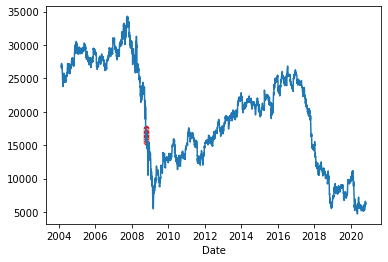

In [199]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

#Plot anomalies
sns.lineplot(x=anomaly_df['Date'], y=sc.inverse_transform(anomaly_df['Close']))
sns.scatterplot(x=anomalies['Date'], y=sc.inverse_transform(anomalies['Close']), color='r')

이상치로 측정된 data 를 상세히 조사